In [ ]:
from IPython.display import clear_output
!pip install scipy==1.2
!pip3 install pybalu==0.2.5
clear_output()
print('Librería PyBalu instalada.')

Librería PyBalu instalada.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from   scipy.ndimage.morphology import binary_fill_holes
import seaborn as sns
import cv2
from   tqdm.auto import tqdm
from   collections import defaultdict
from   pybalu.feature_extraction import lbp_features, haralick_features, gabor_features, hog_features
from   sklearn.metrics import confusion_matrix, accuracy_score
from   sklearn.neighbors import KNeighborsClassifier
from   sklearn.preprocessing import StandardScaler
from   pybalu.feature_selection import clean, sfs
from   pybalu.feature_transformation import normalize, pca
from   sklearn.decomposition import FastICA
from   sklearn.cross_decomposition import PLSRegression

In [ ]:
!wget https://www.dropbox.com/s/1xajq6knp1mm34h/argender.zip
!unzip argender.zip
clear_output()
print('Imagenes cargadas correctamente')

Imagenes cargadas correctamente


In [ ]:
# Funciones para cargar una imagen

def build_string(prefix, num_class, num_img):
    "Función que retorna nombre de imagen válido"
    n_char = str(num_class).zfill(3)
    n_img = str(num_img).zfill(4)
    return prefix + '_' + n_char + '_' + n_img + '.png'

def load_image(num_class, num_img, prefix='argender/face'):
    string = build_string(prefix, num_class, num_img)
    img = plt.imread(string)
    return img

In [ ]:
def split_train_test(X, y, k, batch_train):
    "Función para obtener datos de train y test"
    batch_test = int(X.shape[0]/k) - batch_train
    batch = batch_train + batch_test
    Xtrain = X[: batch_train]
    ytrain = y[: batch_train]
    Xtest = X[batch_train: batch]
    ytest = y[batch_train: batch]

    for i in range(1, k):        
        Xtrain = np.concatenate((Xtrain, X[batch * i : batch * i + batch_train]))
        ytrain = np.concatenate((ytrain, y[batch * i : batch * i + batch_train]))
        Xtest = np.concatenate((Xtest, X[batch * i + batch_train : 2 * batch * i]))
        ytest = np.concatenate((ytest, y[batch * i + batch_train : 2 * batch * i]))
    return Xtrain, ytrain, Xtest, ytest

In [ ]:
def ClassifierKNN(Xtrain, ytrain, Xtest, ytest):
    X = np.concatenate((Xtrain, Xtest), axis=0)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Xtrain = X[:Xtrain.shape[0]]
    Xtest = X[Xtrain.shape[0]:]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(Xtrain, ytrain)
    ypred        = knn.predict(Xtest)
    acc          = accuracy_score(ytest,ypred)
    print('Entrenando con '+str(Xtrain.shape[0])+' muestras y probando con '+str(Xtest.shape[0])+' muestras')
    C = confusion_matrix(ytest,ypred)
    
    return acc,C

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Parámetros del problema:

In [ ]:
K = 2           # Número de clases
N = 700         # Número de imágenes por clase

# Extracción de características
En esta sección se ocupan los métodos LBP, Haralick, Gabor y HoG. En primer lugar mostramos en qué consiste a grandes rasgos cada uno de estos métodos y luego lo empleamos.



## 1) LBP clásico

LBP es un descriptor local de texturas que es construído comparando cada pixel con su vecindario de pixeles más cercanos.

El primer paso para la construcción del LBP es efectuar la codificación. Para esto es necesario considerar para cada pixel su vecindad y digitar un cero o uno dependiendo de la comparación del valor del pixel en cuestión versus el de su vecino. Si el valor del pixel estudiado es mayor que el valor del pixel del vecino, se anota un 1 en la posición del vecino, mientras que si su valor es menor se digita un 0. La imagen de a continuación ejemplifica el primer paso para el pixel marcado en rojo.
<p align="center">
<img src="https://www.pyimagesearch.com/wp-content/uploads/2015/12/lbp_thresholding.jpg" width="500" height="200"/>
<p align="center">


Como consideramos una vecindad de 8 pixeles para el pixel estudiado, tenemos $2^{8}=256$ posibles combinaciones de codificaciones LBP para dicho pixel. Lo siguiente es entonces calcular el valor LBP para el pixel, para esto, lo que hacemos es tomar el 8-bit binario del vecindario obtenido en el paso anterior y convertirlo a número decimal. Este paso es representado en la siguiente figura:

<p align="center">
<img src="https://www.pyimagesearch.com/wp-content/uploads/2015/12/lbp_calculation-1024x299.jpg" width="500" height="200"/>
<p align="center">

Observar que en este ejemplo se comenzó a contar desde el pixel superior derecho y trabajar en sentido horario (podría adoptarse otra convención mientras seas consistente). En el caso de este pixel se obtuvo un resultado de 23. Este proceso se repite para cada uno de los pixeles de la imagen obteniéndose algo similar a lo mostrado en la siguiente figura:

<p align="center">
<img src="https://www.pyimagesearch.com/wp-content/uploads/2015/12/lbp_to_output-1024x519.jpg" width="500" height="200"/>
<p align="center">


El siguiente paso es el Mapeo, proceso en el cual se detectan diferentes posibilidades de patrones segun el número de cambios de valor en la codificación para cada vecindad del pixel. En este sentido, tenemos dos posibilidades: Patrones uniformes y patrones no uniformes. Los patrones uniformes ocurren cuando hay cero cambios de valor y dos (no puede existir un número impar de cambios de valor). los cuales se muestran en la siguiente figura:

<p align="center">
<img src="https://i.stack.imgur.com/AMLGu.png" width="350" height="500"/>
<p align="center">


Se puede observar que el primer y último círculo corresponden a los cero cambios, mientras que los círculos ubicados entre estos dos corresponden a los escenarios posibles para dos cambios (56 posibilidades). De esta forma, tenemos 58 patrones uniformes.

Los patrones no uniformes ocurren cuando hay más de dos cambios. Se consideran no uniformes debido a que hay mucho ruido. De esta manera tenemos $256-58 = 198$ patrones no uniformes que se agruparán en uno solo.

Así, podemos adoptar la siguiente convención: Los dos patrones con cero cambios se les asigna el valor cero y uno respectivamente. Los patrones con dos cambios toman los valores $2,3,4,...,57$ mientras que todos los patrones no uniformes son mapeados al valor 58.

La siguiente figura muestra los procesos recién explicados:

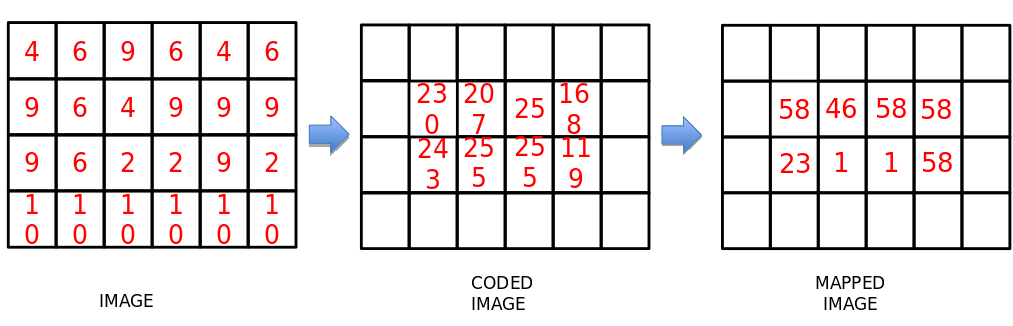

El último paso es el histograma. En este caso se cuenta el número de pixeles que fueron mapeados a cada uno de los 59 posibles patrones. Ese histograma es el descriptor LBP que contiene información sobre la textura de la imagen. En la práctica, para obtener también información posicional sobre la imagen, uno puede particionarla y efectuar el lbp para cada cuadro generado en la imagen tal como se muestra en la figura.




<p align="center">
<img src="https://www.researchgate.net/publication/305820417/figure/fig3/AS:391368460521496@1470320920973/Example-of-histogram-feature-extraction-using-multi-level-local-binary-pattern-MLBP-at.png" width="700" height="400"/>
<p align="center">



[Local Binary Patterns with Python & OpenCV](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/)

[Number of different output labels in Local Binaty Pattern](https://cs.stackexchange.com/questions/19844/number-of-different-output-labels-in-local-binary-pattern)




Extracción de características LBP:

Parámetros LBP

In [ ]:
a = 1           # hdiv
b = 1           # vdiv
Mlbp =  59 * a * b
Xlbp = np.zeros((K * N, Mlbp))     
y = np.zeros((K * N),'int')

Extracción de características LBP

In [ ]:
row = 0
for n_class in tqdm(range(1, K + 1)):
    for n_img in range(1, N + 1):
        img = load_image(n_class, n_img)
        Xlbp[row,:] = lbp_features(img, hdiv=a, vdiv=b, mapping='nri_uniform')
        y[row] = n_class
        row += 1

Obtención datos de entrenamiento y test

In [ ]:
Xtrainlbp, ytrain, Xtestlbp, ytest = split_train_test(Xlbp, y, 2, 630)

## 2) Haralick
Este método, al igual que LBP detecta patrones de texturas en las imágenes. Sin embargo, la manera en que lo hace es totalmente distinta y se centra en un concepto llamado Matriz de Co-currencia.

La matriz de Co-ocurrencia registra cuán seguido aparecen pares de pixeles adyacentes con determinados valore, por ejemplo, cuántas veces aparece el par (1,1), (1,2), (2,3), (2,1), etc. El resultado será una matriz de 255x255 (escala de grises), donde cada celda contiene el conteo de ocurrencias de ese par, por ejemplo, la fila 2, columna 3 contendrá el número de veces que el par (2,3) aparece en la imagen.

El descriptor de Haralick computa cuartro matrices de Co-ocurrencia, correspondiente a las cuatro direcciones siguientes:


1.   De izquierda a derecha.
2.   De arriba hacia abajo.
3.   De la esquina superior izquierda a la esquina inferior derecha (pares diagonales adyacentes)
4. De la esquina superior derecha a la esquina inferior izquierda (pares diagonales adyacentes)

A modo de intuición, notemos que si los valores en la diagonal de la matriz de ocurrencia son altos, significa que los valores en la dirección que define a la matriz de ocurrencia en cuestión son muy similares.

Para la construcción de la matriz de Co-ocurrencia es también necesario definir un parámetro de distancia entre los pixeles, es decir, cuando consideremos por ejemplo la dirección vertical de arriba hacia abajo, los pares a considerar son los que poseen una distancia de tres pixeles en forma vertical. Esta misma idea se aplica para las otras direcciones. La definición de este parámetro es útil para manejar la extracción de características en la imagen considerando si esta posee mucha variación o no en su textura. Por ejemplo, para imágenes con alta variación en su textura es conveniente definir un parámetro de distancia pequeño, mientras que si la variación es baja es conveniente un parámetro de distancia alto.

A continuación de definir las matriz de Co-ocurrencia, se calculan estadísticas descriptivas (14) para cada matriz, las cuales representan propiedades como el contraste, entropía, correlación, homogeneidad, etc. Como resultado se obtienen cuatro vectores de dimensión 14 a los cuales se les calcula el promedio y rango para cada característica. De esta forma, se obtienen 28 características: 14 correspondientes al promedio y 14 correspondientes al rango.



Extracción de características de Haralick:

Parámetros Haralick

In [ ]:
Mhar = 28
dist = 3
Xhar  = np.zeros((K*N, Mhar))
y = np.zeros((K * N),'int')

Extracción características de Haralick

In [ ]:
row = 0
for n_class in tqdm(range(1, K + 1)):
    for n_img in range(1, N + 1):
        img = load_image(n_class, n_img)
        Xhar[row,:] = haralick_features(img, distance=dist)
        y[row] = n_class
        row += 1

Obtenemos datos de entrenamiento y test

In [ ]:
Xtrainhar, ytrain, Xtesthar, ytest = split_train_test(Xhar, y, 2, 630)

## 3) Gabor
La técnica de reconocimiento de patrones de Gabor también es a partir de la detección de texturas. Su explicación es un poco más sencilla que los casos anteriores. Lo que se hace es, a partir de la ponderación de una Gaussiana con una función sinusoidal, crear una máscara (patrón específico de textura). El siguiente paso es escoger un número de rotaciones y número de dilataciones que trabajarán sobre dicha máscara generando un número de rotaciones x dilataciones máscaras con las que se efectúa la convolución sobre la imagen. De esta manera, sectores que tengan un valor alto en la convolución con una máscara significará que en ese sector dicho patrón está presente.

Finalmente, lo que se hace es, por cada matriz convolutiva generada, se efectúa una sumatoria de sus valores que darán como resultado los patrones de Gabor. adicionalmente, se consideran tres patrones más que corresponden al valor mínimo, máximo y rango normalizado.


Extracción patrones de Gabor:

Parámetros Gabor

In [ ]:
rot = 8
dilat = 8
Mgab = rot * dilat + 3

Xgab = np.zeros((K*N, Mgab))
y = np.zeros((K * N),'int')

Extracción características de Gabor

In [ ]:
row = 0
for n_class in tqdm(range(1, K + 1)):
    for n_img in range(1, N + 1):
        img = load_image(n_class, n_img)
        Xgab[row,:] = gabor_features(img, rotations=rot, dilations=dilat)
        y[row] = n_class
        row += 1

Obtención datos de entrenamiento y test

In [ ]:
Xtraingab, ytrain, Xtestgab, ytest = split_train_test(Xgab, y, 2, 630)

## 4) HoG

En este caso lo que se hace es trabajar con los llamados histogramas orientados de gradiente.
El primer caso es, a partir de una imagen, calcular su gradiente en la dirección x e y por separado. El resultado serán dos imágenes que poseen como valor alto los lugares en que en la imagen original habían grandes cambios de color en la dirección del gradiente respectivo.

Como los gradientes son vectores, podemos calcular su magnitud y ángulo. Con estos datos podemos calcular el histograma de ocho direcciones del gradiente.(arriba, abajo, izquierda, derecha y diagonales).

Para cada dirección seleccionada se considera el ángulo de dicha dirección más menos 22.5 grados. por ejemplo, si consideramos la dirección hacia a derecha, el ángulo es cero por lo tanto la zona de interés va desde los -22.5 grados hasta los 22.5 grados, barriendo en total una zona de 45 grados. Acto seguido, se revisa en la imagen de ángulos cuáles valores están entre los ángulos de inteŕes. Conociendo las coordenadas de dichos pixeles, lo que se hace es sumar sus valores en la imagen correspondiente a las magnitudes de los gradientes. El valor resultante vendría siendo la "frecuencia" en la dirección uno para el histograma.

En la práctica, los autores proponen particionar la imagen y efectuar este proceso para cada una de las particiones. Las features resultantes serán la concatenación de los histogramas para cada partición de la la imagen.

Parámetros HoG

In [ ]:
vwind = 3
hwind = 3
bins = 9
Mhog = vwind * hwind * bins

Xhog  = np.zeros((K*N,Mhog))
y     = np.zeros((K*N),'int') 3

Extracción características Hog

In [ ]:
row = 0
for n_class in tqdm(range(1, K + 1)):
    for n_img in range(1, N + 1):
        img = load_image(n_class, n_img)
        Xhog[row,:] = hog_features(img, v_windows=vwind, h_windows=hwind, n_bins=bins) 
        y[row] = n_class
        row += 1

Obtención datos de entrenamiento y test

In [ ]:
Xtrainhog, ytrain, Xtesthog, ytest = split_train_test(Xhog, y, 2, 630)

# Accuracy sin filtrar

En esta sección obtendremos el accuracy utilizando las características lbp, haralick, Gabor y Hog por separado sin efectuar ninguna técnica de limpieza ni reducción de dimensionalidad. Luego mostramos el accuracy utilizando como matriz de características la concatenación de todos los casos anteriores.

1) Accuracy LBP

Entrenando con 1260 muestras y probando con 140 muestras
LBP Accuracy = 87.85714285714286%


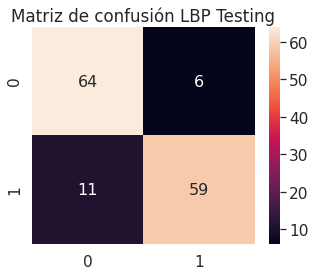

In [ ]:
acc, C = ClassifierKNN(Xtrainlbp, ytrain, Xtestlbp, ytest)
print('LBP Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de confusión LBP Testing')
plt.show()

2) Accuracy Haralick

Entrenando con 1260 muestras y probando con 140 muestras
Haralick Accuracy = 50.0%


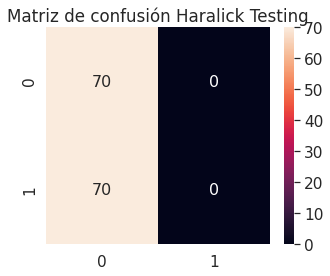

In [ ]:
acc, C = ClassifierKNN(Xtrainhar, ytrain, Xtesthar, ytest)
print('Haralick Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de confusión Haralick Testing')
plt.show()

3) Accuracy Gabor

Entrenando con 1260 muestras y probando con 140 muestras
Gabor Accuracy = 78.57142857142857%


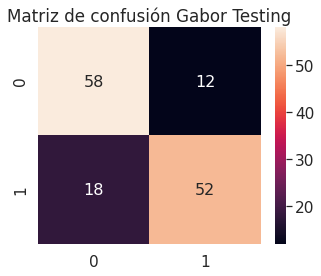

In [ ]:
acc, C = ClassifierKNN(Xtraingab, ytrain, Xtestgab, ytest)
print('Gabor Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de confusión Gabor Testing')
plt.show()

4) Accuracy HoG

Entrenando con 1260 muestras y probando con 140 muestras
HoG Accuracy = 75.0%


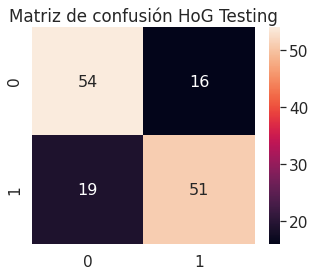

In [ ]:
acc, C = ClassifierKNN(Xtrainhog, ytrain, Xtesthog, ytest)
print('HoG Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de confusión HoG Testing')
plt.show()

5) Accuracy concatenación Features

In [ ]:
Xtrain = np.concatenate((Xtrainlbp, Xtrainhar, Xtraingab, Xtrainhog), axis=1)
Xtest = np.concatenate((Xtestlbp, Xtesthar, Xtestgab, Xtesthog), axis=1)

Entrenando con 1260 muestras y probando con 140 muestras
Concatenación Features Accuracy = 87.85714285714286%


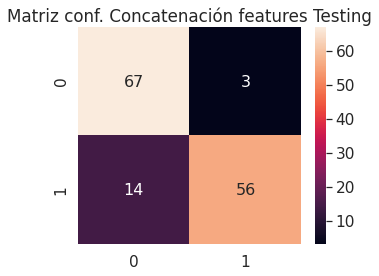

In [ ]:
acc, C = ClassifierKNN(Xtrain, ytrain, Xtest, ytest)
print('Concatenación Features Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz conf. Concatenación features Testing')
plt.show()

# Clean 

Efectuamos clean y obtenemos índices de dichas características

In [ ]:
sclean       = clean(Xtrain)   
Xtrain_clean = Xtrain[:, sclean]   
Xtest_clean  = Xtest[:, sclean]
print('Seleccionadas '+str(len(sclean))+' de '+str(Xtrain.shape[1])+' características')

Seleccionadas 184 de 235 características


Efectuamos clasificación con dichas características

Entrenando con 1260 muestras y probando con 140 muestras
Clean Accuracy = 87.14285714285714%


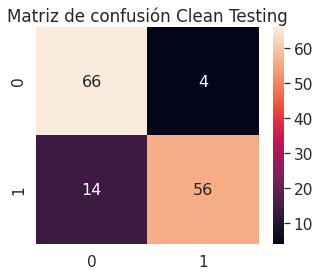

In [ ]:
acc, C = ClassifierKNN(Xtrain_clean, ytrain, Xtest_clean, ytest)
print('Clean Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de confusión Clean Testing')
plt.show()

# Normalización MinMax para los datos

In [ ]:
X = np.concatenate((Xtrain_clean, Xtest_clean), axis=0)
scaler = StandardScaler()
Xnorm = scaler.fit_transform(X)

Xtrain_norm = Xnorm[:Xtrain_clean.shape[0]]
Xtest_norm = Xnorm[Xtrain_clean.shape[0]:]

# Selección de características

1) SFS 50 features

Entrenando con 1260 muestras y probando con 140 muestras
SFS Accuracy = 91.42857142857143%


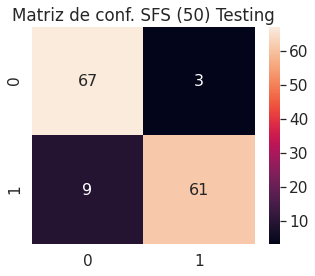

In [ ]:
n_sfs = 50

sel = sfs(Xtrain_norm, ytrain, n_sfs, show=False)    
Xtrain_sfs = Xtrain_norm[:,sel] 
Xtest_sfs  = Xtest_norm[:,sel]

acc,C = ClassifierKNN(Xtrain_sfs,ytrain,Xtest_sfs,ytest)
print('SFS Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de conf. SFS (50) Testing')
plt.show()

2) PLSR 9 componentes

Entrenando con 1260 muestras y probando con 140 muestras
PLSR Accuracy = 92.85714285714286%


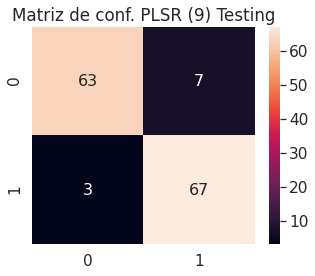

In [ ]:
plsr = PLSRegression(n_components=9)
plsr.fit(Xtrain_norm, ytrain)

Xtrain_plsr = plsr.transform(Xtrain_norm)
Xtest_plsr  = plsr.transform(Xtest_norm)

acc,C = ClassifierKNN(Xtrain_plsr,ytrain,Xtest_plsr,ytest)
print('PLSR Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de conf. PLSR (9) Testing')
plt.show()

### Selección de características sobre las elegidas por SFS

3) PCA 7 componentes


Entrenando con 1260 muestras y probando con 140 muestras
PCA Accuracy = 88.57142857142857%


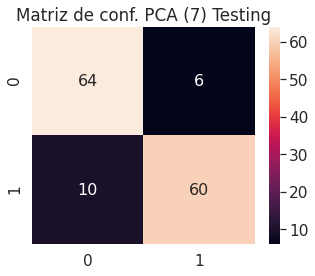

In [ ]:
Xtrain_pca, _, A, Xm, _ = pca(Xtrain_sfs, n_components=7) 
Xtest_pca = np.matmul(Xtest_sfs - Xm, A) 
acc,C = ClassifierKNN(Xtrain_pca,ytrain,Xtest_pca,ytest)

print('PCA Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de conf. PCA (7) Testing')
plt.show()

4) ICA 7 componentes

Entrenando con 1260 muestras y probando con 140 muestras
ICA Accuracy = 88.57142857142857%


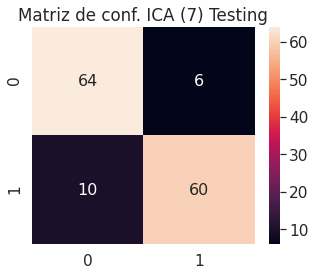

In [ ]:
ica = FastICA(n_components=7, random_state=0)
ica.fit(Xtrain_sfs, ytrain) 
Xtrain_ica = ica.transform(Xtrain_sfs)
Xtest_ica  = ica.transform(Xtest_sfs)

acc,C = ClassifierKNN(Xtrain_ica, ytrain, Xtest_ica,ytest)
print('ICA Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de conf. ICA (7) Testing')
plt.show()

### Concatenamos las mejores features extraídas (Pca, Ica y plsr)

Entrenando con 1260 muestras y probando con 140 muestras
Concatenación Accuracy = 93.57142857142857%


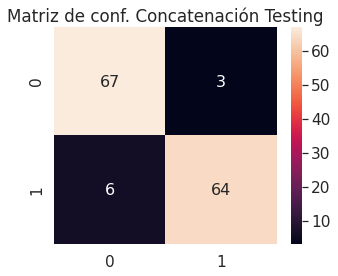

In [ ]:
Xtrain_con = np.concatenate((Xtrain_pca, Xtrain_ica, Xtrain_plsr),axis=1)
Xtest_con  = np.concatenate((Xtest_pca ,Xtest_ica , Xtest_plsr),axis=1)

acc,C = ClassifierKNN(Xtrain_con,ytrain,Xtest_con,ytest)
print('Concatenación Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de conf. Concatenación Testing')
plt.show()

5) Efectuamos SFS 9 features (paso final)

Entrenando con 1260 muestras y probando con 140 muestras
Testing Accuracy = 95.71428571428572%


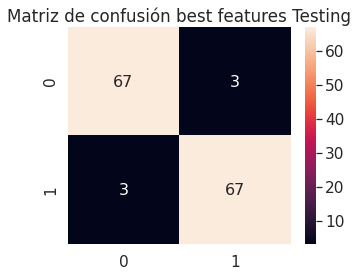

In [ ]:
sel = sfs(Xtrain_con, ytrain,9, show=False) 
Xtrain_fin = Xtrain_con[:,sel] 
Xtest_fin  = Xtest_con[:,sel] 
  
acc, C = ClassifierKNN(Xtrain_fin,ytrain,Xtest_fin,ytest)
print('Testing Accuracy = '+str(acc*100)+'%')

plt.figure(figsize=(5,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(C, annot=True, annot_kws={"size": 16}) # font size
plt.title('Matriz de confusión best features Testing')
plt.show()